## Data606 - Capstone Project
```
Group H
Malav Patel, Kent Butler
Prof. Unal Sokaglu
```

This project is about performing time-series analysis on climate data analysis data.



# Research

### References

Some explanations of earth sciences statistics:
https://pjbartlein.github.io/REarthSysSci/ltms-and-anomalies.html

NOAA PSL NCEP-NCAR datasets:  https://psl.noaa.gov/data/gridded/data.ncep.reanalysis.html

NOAA PSL, other recognized data sources directory: https://psl.noaa.gov/data/help/othersources/

Global environmental policy timeline, https://www.boell.de/en/2022/05/28/international-environmental-policy-timeline

OECD convergence of policy, climate,and economy: https://www.oecd.org/

NASA climate time machine: https://climate.nasa.gov/interactives/climate-time-machine

### Factoids

* All of the plastic waste produced in the world in 2019 alone weighs as much as 35,000 Eiffel Towers – 353 million tons  - [*Organization for Economic Cooperation and Development (OECD)*](https://www.boell.de/en/2022/05/28/international-environmental-policy-timeline)



## Application Parameters

Note: algorithm tuning is done with declaration of the model.

In [63]:
import pandas as pd
from datetime import datetime as dt
import datetime

In [64]:
debug = True

DRIVE_PATH = "/content/drive/MyDrive/data606"

# Set the location of this script in GDrive
SCRIPT_PATH = DRIVE_PATH + "/src/"

# Root Path of the data on the cloud drive
DATA_ROOT = DRIVE_PATH + "/data/"

# Model to use
MODEL_NAME = 'LSTMv3'

# Location of logged output prediction data
LOG_PATH = DATA_ROOT + "/preds/"

# Journal file
JOURNAL_LOG = SCRIPT_PATH + "cv-results.csv"

# Device to run on
run_on_device =  'cpu' # 'cuda'

# Start including data from this date
START_DATE =  pd.to_datetime(dt.fromisoformat('1950-01-01'))
# Stop including data after this date
END_DATE = pd.to_datetime(dt.fromisoformat('2015-12-01'))

---

**Model Configuration**

---

**Basic model params**

In [65]:
# History lookback in network
INPUT_WINDOW = 30
# How far forward to predict
LABEL_WINDOW = 1
# How many to move forward for start of next label
SHIFT = 5
# Ratio of test data to train data - used for split
TEST_RATIO = 0.2
# 0..1 percent of data to use as validation
VALIDATION_RATIO = 0.1
# Num epochs
NUM_EPOCHS = 300

**Configure Predictions**

In [66]:
# Label to predict
TARGET_LABEL = 'landSeaAvgTemp'
TARGET_LABELS = ['landSeaAvgTemp']

# Base dataset
TEMP_DATA = {'filename':'GlobalTemperatures.csv',
             'feature_map':{'LandAndOceanAverageTemperature':'landSeaAvgTemp'},
             'date_col':'dt'}
#TEMP_DATA = {'filename':'GlobalTemperatures.csv',
#              'feature_map':{'LandAverageTemperature':'landAvgTemp',	'LandMaxTemperature':'landMaxTemp',	'LandMinTemperature':'landMinTemp',	'LandAndOceanAverageTemperature':'landSeaAvgTemp'},
#               'date_col':'dt'}


# Datasets
CO2_DATA = {'filename':"atmospheric-co2.csv",
            'feature_map':{'Carbon Dioxide (ppm)':'co2', 'Seasonally Adjusted CO2 (ppm)':'co2_seas'},
            'date_map':{'Year':'year','Month':'month'}}

SEAICE_DATA = {'filename':"seaice.csv",
               'feature_map':{'     Extent':'ice_extent','    Missing':'ice_missing'},
               'date_map':{' Month':'month','Year':'year',' Day':'day'}}

WEATHER_DATA = {'filename':"finalDatasetWithRain.csv",
                'feature_map':{'air_x':'air_x','air_y':'air_y','uwnd':'uwnd'},
                'date_col':'time'}

VOLCANO_DATA = {'filename':'eruptions-conditioned.csv',
                'feature_map':{'vei':'volcanic_idx'},
                'date_map':{'start_year':'year','start_month':'month'}}

FOREST_DATA = {'filename':'WorldForestCover-Interpolated.csv',
               'feature_map':{'PctCover-Int':'pct_forest_cover'},
               'date_col':'date'}

SUNSPOT_DATA = {'filename':'sunspotnumber.csv',
               'feature_map':{'suns_spot_number':'sunspot_num'},
               'date_map':{'year':'year'}}

POLICY_DATA = {'filename':'GlobalEnvPolicies.csv',
               'feature_map':{'EventRating':'policy_rate'},
               'date_col':'date'}

#GHG_DATA = {'filename':'greenhouse_gas_inventory_data.csv',
#            'feature_map':{''},
#            'date_map':{'Year':'year'}}
#ALL_DATASETS = []
#ALL_DATASETS = [SUNSPOT_DATA]
ALL_DATASETS = [FOREST_DATA]
#ALL_DATASETS = [CO2_DATA, SEAICE_DATA]
#ALL_DATASETS = [CO2_DATA, SEAICE_DATA, WEATHER_DATA]
#ALL_DATASETS = [CO2_DATA, SEAICE_DATA, VOLCANO_DATA]
#ALL_DATASETS = [CO2_DATA, SEAICE_DATA, WEATHER_DATA, VOLCANO_DATA]
#ALL_DATASETS = [CO2_DATA, SEAICE_DATA, WEATHER_DATA, VOLCANO_DATA, FOREST_DATA]
#ALL_DATASETS = [CO2_DATA, SEAICE_DATA, WEATHER_DATA, VOLCANO_DATA, FOREST_DATA, SUNSPOT_DATA]
#ALL_DATASETS = [VOLCANO_DATA, FOREST_DATA, SUNSPOT_DATA]
#ALL_DATASETS = [VOLCANO_DATA, FOREST_DATA, SUNSPOT_DATA, CO2_DATA]
#ALL_DATASETS = [VOLCANO_DATA, FOREST_DATA, SUNSPOT_DATA, CO2_DATA, SEAICE_DATA]
#ALL_DATASETS = [CO2_DATA, SEAICE_DATA, VOLCANO_DATA, FOREST_DATA, SUNSPOT_DATA]

#ALL_DATASETS = [POLICY_DATA,CO2_DATA]


In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
%cd $SCRIPT_PATH

/content/drive/MyDrive/data606/src


In [69]:
# Load util class
%run -i "./ProjectUtil.ipynb"

In [70]:
# Load util class
%run -i "./WindowGenerator.ipynb"

              A   B      C
2011-01-02   97   1  0.125
2011-01-03   98   2  0.250
2011-01-04   99   3  0.375
2011-01-05  100   4  0.500
2011-01-06  101   5  0.625
2011-01-07  102   6  0.750
2011-01-08  103   7  0.875
2011-01-09  104   8  1.000
2011-01-10  105   9  1.125
2011-01-11  106  10  1.250
2011-01-12  107  11  1.375
2011-01-13  108  12  1.500
2011-01-14  109  13  1.625
2011-01-15  110  14  1.750
2011-01-16  111  15  1.875
2011-01-17  112  16  2.000
2011-01-18  113  17  2.125
2011-01-19  114  18  2.250
2011-01-20  115  19  2.375
2011-01-21  116  20  2.500
2011-01-22  117  21  2.625
2011-01-23  118  22  2.750
Shape: (22, 3)
--- Case 1 ------
 input_width=None, label_width=1, shift=1, label_columns=['A']
Correct outcome - assert error
--- Case 2 ------
 input_width=4, label_width=1, shift=1, label_columns=['A']
Window Generator::
	Input size: 4
	Label size: 1
	Shift: 1
	Batch size: 4
	Total window size: 5
	Label start: 4
input_arr: (22, 2)
label_arr: (22, 1)
Frames: (18, 4, 2)
First

# Data Load

In [71]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns; sns.set()
plt.rcParams["figure.figsize"] = (10,6)
import warnings

In [72]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
%matplotlib inline

---

**Initial Data Load**

---

In [73]:
# Load util class
%run -i "./Dataset_Merger.ipynb"

In [74]:
# Declare a merger compatible with our source data and our target dataset we want to merge into
merger = Dataset_Merger(data_path=DATA_ROOT, start_date=START_DATE, end_date=END_DATE, debug=True)

------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/GlobalTemperatures.csv

 ### Defaulting df_aggr to reference df
------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3192 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   float64
 6   LandMinTemperatureUncert

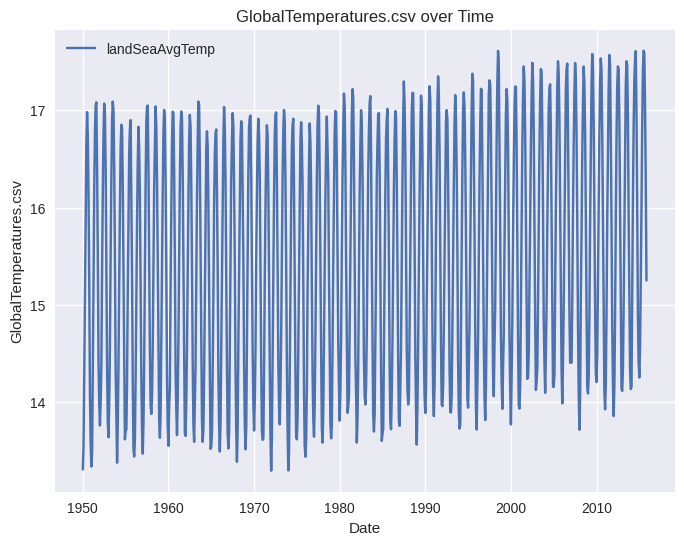

------------------------------------------
 ### assess_granularity for cols: ['landSeaAvgTemp']
 ### After grouping y/m/d: 791
 ### After grouping y/m: 791
 ### After grouping y: 66
Dataset assessed at timestep freq: M


In [75]:
# Start by merging initial dataset
df_merge = merger.merge_dataset(TEMP_DATA['filename'],
                                TEMP_DATA['feature_map'],
                                 date_col=TEMP_DATA['date_col'],
                                 add_cyclic=True)

# And store an indication of what our step scale is
cols = list(TEMP_DATA['feature_map'].values())
STEP_FREQ = merger.assess_granularity(df_merge, cols)

In [76]:
print(assess_na(df_merge))

  _date_  day year month landSeaAvgTemp month-sin month-cos
0    0.0  0.0  0.0   0.0            0.0       0.0       0.0


---

**Merge Additional Data**

---

------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/WorldForestCover-Interpolated.csv

------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              846 non-null    object 
 1   pct_forest_cover  846 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.3+ KB
------------------------------------------
 ### preprocess_dates with date_col: date
 ### Convert from given col date
------------------------------------------
 ### Creating std date columns
 ### ## Case 2 for df::
<bound method DataFrame.info of            date  pct_forest_cover     _date_
0    1950-01-01         36.872263 1950-01-01
1    1950-02-01         36.868748 1950-02-01
2    1950-03

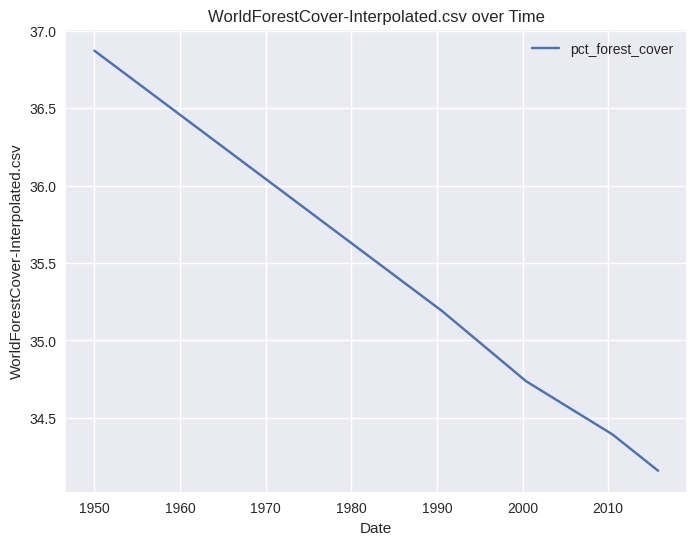

  _date_  day year month landSeaAvgTemp month-sin month-cos pct_forest_cover
0    0.0  0.0  0.0   0.0            0.0       0.0       0.0              0.0


In [77]:
for dataset in ALL_DATASETS:
  if ('date_map' in dataset):
    df_merge = merger.merge_dataset(dataset['filename'],
                                    feature_map=dataset['feature_map'],
                                    df_aggr=df_merge,
                                    date_map=dataset['date_map'])
  else:
    df_merge = merger.merge_dataset(dataset['filename'],
                                feature_map=dataset['feature_map'],
                                df_aggr=df_merge,
                                date_col=dataset['date_col'])
  print(assess_na(df_merge))

In [78]:
df_merge

,_date_,day,year,month,landSeaAvgTemp,month-sin,month-cos,pct_forest_cover
0,1950-01-01,1.0,1950,1,13.311,0.500000,8.660254e-01,36.872263
1,1950-02-01,1.0,1950,2,13.554,0.866025,5.000000e-01,36.868748
2,1950-03-01,1.0,1950,3,14.296,1.000000,6.123234e-17,36.865573
3,1950-04-01,1.0,1950,4,15.093,0.866025,-5.000000e-01,36.862058
4,1950-05-01,1.0,1950,5,16.033,0.500000,-8.660254e-01,36.858656
...,...,...,...,...,...,...,...,...
786,2015-07-01,1.0,2015,7,17.611,-0.500000,-8.660254e-01,34.172678
787,2015-08-01,1.0,2015,8,17.589,-0.866025,-5.000000e-01,34.168942
788,2015-09-01,1.0,2015,9,17.049,-1.000000,-1.836970e-16,34.165207
789,2015-10-01,1.0,2015,10,16.290,-0.866025,5.000000e-01,34.161592


---

**Assess correlations**

---

In [79]:
# Assess correlations between all data columns
df_corr = df_merge.corr()

In [80]:
# Identify the columns which have medium to strong correlation with target
df_corr_cols = df_corr[df_corr[TARGET_LABEL] > 0.5]

In [81]:
# Drop the target from the correlation results in case we want to use this reduced set
#    in place of the full set
df_corr_cols = df_corr_cols.drop(columns=[])

In [82]:
# Extract just the column names
corr_cols = df_corr_cols.index.values

In [83]:
if debug:
  print(corr_cols)

['landSeaAvgTemp']


Text(0.5, 1.0, 'Heatmap of correlation among variables')

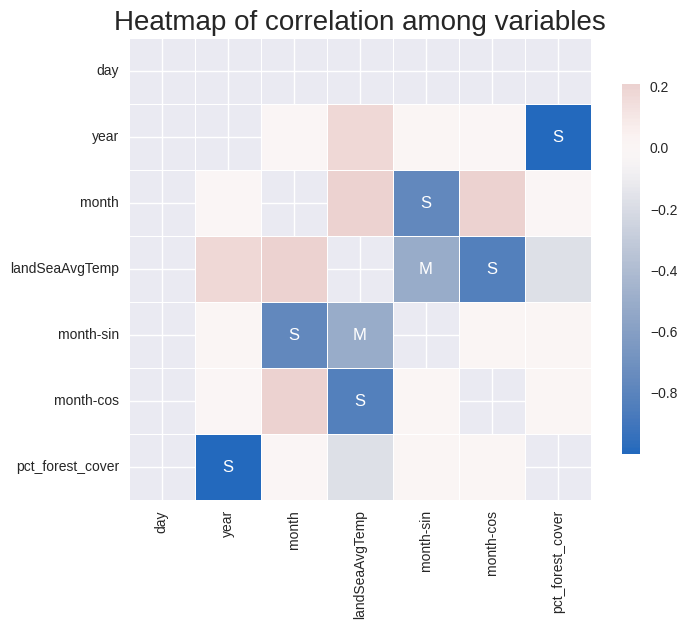

In [84]:
# Add labels
labels = np.where(np.abs(df_corr) > 0.75, 'S',
                  np.where(np.abs(df_corr) > 0.5, 'M',
                           np.where(np.abs(df_corr) > 0.25, 'W', '')))
# Plot the matrix
plt.figure(figsize=(8,6))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt = '', linewidths = .5,
            cmap='vlag', cbar_kws={'shrink':0.8});
plt.title('Heatmap of correlation among variables', fontsize=20)

---

**Prepare for Modeling**

---

In [85]:
# It's time to set date as index and remove from dataset
df_merge.set_index(merger.DATE_COL, inplace=True, drop=True)

In [86]:
df_merge

,day,year,month,landSeaAvgTemp,month-sin,month-cos,pct_forest_cover
_date_,,,,,,,
1950-01-01,1.0,1950,1,13.311,0.500000,8.660254e-01,36.872263
1950-02-01,1.0,1950,2,13.554,0.866025,5.000000e-01,36.868748
1950-03-01,1.0,1950,3,14.296,1.000000,6.123234e-17,36.865573
1950-04-01,1.0,1950,4,15.093,0.866025,-5.000000e-01,36.862058
1950-05-01,1.0,1950,5,16.033,0.500000,-8.660254e-01,36.858656
...,...,...,...,...,...,...,...
2015-07-01,1.0,2015,7,17.611,-0.500000,-8.660254e-01,34.172678
2015-08-01,1.0,2015,8,17.589,-0.866025,-5.000000e-01,34.168942
2015-09-01,1.0,2015,9,17.049,-1.000000,-1.836970e-16,34.165207


**Assess Periodicity**

```
# removed kendalltau analysis
# Replace with fft graph of major freqs?
```


**Resampling**

This is being performed during the dataset merging phase.

Ready for time series modeling.

---

**Data conversion for model**

---

**Extract labels**

Time series creates a supervised learning problem out of moving data.

**Dataset stats**

In [87]:
NUM_FEATURES = len(df_merge.columns)

# Capture stats on number of non-metadata columns - so, exclude some stuff
#NET_NUM_FEATURES = len(set(df_merge.columns) - set(['year','month','day']))

In [88]:
# Keep rows aside for post validation?
TOTAL_ROWS = df_merge.shape[0]
NUM_VALIDATION = math.floor(TOTAL_ROWS * VALIDATION_RATIO)
WORKING_ROWS = TOTAL_ROWS - NUM_VALIDATION

In [89]:
# Split non-validation rows into train/test
NUM_TEST = math.floor(WORKING_ROWS * TEST_RATIO)
NUM_TRAIN = WORKING_ROWS - NUM_TEST

In [90]:
print(f'Num features: {NUM_FEATURES}')
print(f'Total rows: {TOTAL_ROWS}')
print(f'Validation rows: {NUM_VALIDATION}')
print(f'Train rows: {NUM_TRAIN}')
print(f'Test rows: {NUM_TEST}')

Num features: 7
Total rows: 791
Validation rows: 79
Train rows: 570
Test rows: 142


**Split into Train/Test**

In [91]:
df_train = df_merge.iloc[:NUM_TRAIN, :]
df_val = df_merge.iloc[NUM_TRAIN:NUM_TRAIN+NUM_VALIDATION, :]
df_test = df_merge.iloc[NUM_TRAIN+NUM_VALIDATION:, :]

In [92]:
y_train = df_train[TARGET_LABEL]
y_val = df_val[TARGET_LABEL]
y_test = df_test[TARGET_LABEL]

In [93]:
if debug:
  print(f'df_train: {df_train.shape}')
  print(f'y_train: {y_train.shape}')
  print(f'df_test: {df_test.shape}')
  print(f'y_test: {y_test.shape}')
  print(f'df_val: {df_val.shape}')
  print(f'y_val: {y_val.shape}')

df_train: (570, 7)
y_train: (570,)
df_test: (142, 7)
y_test: (142,)
df_val: (79, 7)
y_val: (79,)


**Scale data**

Doing this **after** the split means that training data doesn't get unfair advantage of looking ahead into the 'future' during test & validation.

In [94]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [95]:
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer,  QuantileTransformer, Normalizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import tensorflow as tf


In [96]:
# Create small pipeline for numerical features
numeric_pipeline = Pipeline(steps = [('impute', SimpleImputer(strategy='mean')),
                                    ('scale', MinMaxScaler())])

In [97]:
# get names of numerical features
con_lst = df_train.select_dtypes(include='number').columns.to_list()

In [98]:
# Transformer for applying Pipelines
column_transformer = ColumnTransformer(transformers = [('number', numeric_pipeline, con_lst)])

In [99]:
# Transform data features
X_train_tx = column_transformer.fit_transform(df_train)
X_test_tx = column_transformer.transform(df_test)
X_val_tx = column_transformer.transform(df_val)
X_train_tx.shape, X_test_tx.shape, X_val_tx.shape

((570, 7), (142, 7), (79, 7))

In [100]:
# Transform labels
label_scaler = MinMaxScaler()
y_train_tx = label_scaler.fit_transform(y_train.values.reshape(-1, 1))

In [101]:
# Slice labels - we cannot predict anything inside the first INPUT_WINDOW
#y_train_tx = y_train_tx[INPUT_WINDOW:]

In [102]:
if debug:
  print(f'X_train_tx {X_train_tx.shape}: {X_train_tx[0]}')
  print(f'y_train_tx {y_train_tx.shape}: {y_train_tx[0]}')

X_train_tx (570, 7): [0.         0.         0.         0.00318862 0.75       0.9330127
 1.        ]
y_train_tx (570, 1): [0.00318862]


**Extract X and y**

Normally we would do this by explicitly extracting data from our df.

However for a time series, we're going to create many small supervised learning sets, so a set of X and y pairs.

We should end up with data in a shape ready for batched network input:

`batches X time_steps X features`



In [103]:
if debug:
  print(f'X_train_tx: {X_train_tx.shape}')
  print(f'y_train_tx: {y_train_tx.shape}')

X_train_tx: (570, 7)
y_train_tx: (570, 1)


In [104]:
NUM_LABELS = y_train_tx.shape[1]

---

**Modeling**

---

In [105]:
# These are the features we are going to be modeling
COLS = list(df_merge.columns)

**Slice into Batches**

In [106]:
windower = TfWindowGenerator(input_width=INPUT_WINDOW,
                             label_width=LABEL_WINDOW,
                             shift=SHIFT,
                             batch_size=INPUT_WINDOW,
                             debug=False)

In [107]:
windower

Window Generator::
	Input size: 30
	Label size: 1
	Shift: 1
	Batch size: 30
	Total window size: 31
	Label start: 30

In [108]:
X_train_tx.shape, y_train_tx.shape

((570, 7), (570, 1))

In [109]:
ds = windower.get_ds_from_arrays(X_train_tx, y_train_tx)

input_arr: (570, 7)
label_arr: (570, 1)
## Inputs: (540, 30, 7)
## Labels: (540, 1, 1)


In [110]:
# Use tensorflow util to batch the timeseries
# #   note that targets assume first label starts at 0 (vs. targets[INPUT_WINDOW])
# ds = tf.keras.utils.timeseries_dataset_from_array(
#     data=X_train_tx,
#     targets=y_train_tx,
#     batch_size=INPUT_WINDOW*2,
#     sequence_length=INPUT_WINDOW )

In [111]:
for batch in ds:
  X,y = batch
  print(f'batch size: {X.shape},{y.shape}')

batch size: (30, 30, 7),(30, 1, 1)
batch size: (30, 30, 7),(30, 1, 1)
batch size: (30, 30, 7),(30, 1, 1)
batch size: (30, 30, 7),(30, 1, 1)
batch size: (30, 30, 7),(30, 1, 1)
batch size: (30, 30, 7),(30, 1, 1)
batch size: (30, 30, 7),(30, 1, 1)
batch size: (30, 30, 7),(30, 1, 1)
batch size: (30, 30, 7),(30, 1, 1)
batch size: (30, 30, 7),(30, 1, 1)
batch size: (30, 30, 7),(30, 1, 1)
batch size: (30, 30, 7),(30, 1, 1)
batch size: (30, 30, 7),(30, 1, 1)
batch size: (30, 30, 7),(30, 1, 1)
batch size: (30, 30, 7),(30, 1, 1)
batch size: (30, 30, 7),(30, 1, 1)
batch size: (30, 30, 7),(30, 1, 1)
batch size: (30, 30, 7),(30, 1, 1)


**Prep GPU**

In [112]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


---

**Build and Train**

---

**Build model**

In [113]:
# Load model class
%run -i "./ModelFactory.ipynb"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/data606/src


In [114]:
# Use factory for flexible selection
mf = ModelFactory(window_size=INPUT_WINDOW,label_window=LABEL_WINDOW,num_labels=NUM_LABELS,num_epochs=NUM_EPOCHS,debug=True)

### Building ModelDensev1::
### Building ModelLSTMv1::
### Building ModelLSTMv2::
### Building ModelLSTMv3::


In [115]:
mf

window_size: 30
label_window: 1
num_labels: 1
num_epochs: 300

In [116]:
print(f'Initializing model: {MODEL_NAME}')
model = mf.get(MODEL_NAME)

Initializing model: LSTMv3


In [117]:
model

window_size: 30
label_window: 1
num_labels: 1
num_epochs: 300

**Train model**

In [118]:
model_history = model.train(dataset=ds, num_features=NUM_FEATURES)

Epoch 1/300
18/18 [==============================] - 3s 6ms/step - loss: 0.1710
Epoch 2/300
18/18 [==============================] - 0s 5ms/step - loss: 0.1146
Epoch 3/300
18/18 [==============================] - 0s 6ms/step - loss: 0.0645
Epoch 4/300
18/18 [==============================] - 0s 5ms/step - loss: 0.1192
Epoch 5/300
18/18 [==============================] - 0s 6ms/step - loss: 0.0913
Epoch 6/300
18/18 [==============================] - 0s 5ms/step - loss: 0.1052
Epoch 7/300
18/18 [==============================] - 0s 5ms/step - loss: 0.0797
Epoch 8/300
18/18 [==============================] - 0s 5ms/step - loss: 0.0580
Epoch 9/300
18/18 [==============================] - 0s 6ms/step - loss: 0.0563
Epoch 10/300
18/18 [==============================] - 0s 5ms/step - loss: 0.0516
Epoch 11/300
18/18 [==============================] - 0s 6ms/step - loss: 0.0475
Epoch 12/300
18/18 [==============================] - 0s 5ms/step - loss: 0.0322
Epoch 13/300
18/18 [=================

In [119]:
# Capture stat
num_epochs = len(model_history.history['loss'])

**Test Predictions**

In [120]:
num_predictions = y_test.shape[0]-INPUT_WINDOW-LABEL_WINDOW
print(f'Num Exp. Predictions: {num_predictions} == {y_test.shape[0]} - {INPUT_WINDOW}')

preds = []
pred_dates = []
y_test_vals = []

Num Exp. Predictions: 111 == 142 - 30


In [121]:
# Defaults to a single Day
STEP_OFFSET = pd.DateOffset()

if (STEP_FREQ == 'M'):
  STEP_OFFSET = pd.DateOffset(months=1)
else:
  STEP_OFFSET = pd.DateOffset(years=1)

In [122]:
for p in range(num_predictions):
  # Prepare inputs
  print(f'Pred range: x_test_tx[{p}:{p+INPUT_WINDOW}]')
  X_pred = X_test_tx[p:p+INPUT_WINDOW,:].reshape(-1, INPUT_WINDOW, NUM_FEATURES)

  # Prepare outputs
  label_start_index = p+INPUT_WINDOW
  print(f'Exp output: y_test[{label_start_index}:{label_start_index + LABEL_WINDOW}]')
  y_test_vals.append(y_test[label_start_index:label_start_index + LABEL_WINDOW])

  if (LABEL_WINDOW == 1):
    print(f'Pred date: {df_test.index[label_start_index]}')
  else:
    print(f'Pred dates: {df_test.index[label_start_index]} + {LABEL_WINDOW-1} steps')

  # Predict
  batch_preds = model.predict(X_pred)
  print(f'## Batch step: {batch_preds.shape}')
  if (len(batch_preds.shape) > 2):
    #batch_preds = batch_preds[0]
    batch_preds = batch_preds.reshape(LABEL_WINDOW, -1)

  # Re-Scale
  pred_vals = label_scaler.inverse_transform(batch_preds)
  # Reduce to single array
  pred_vals = np.squeeze(pred_vals)

  # if (len(pred_vals.shape) > 1):
  #   #pred_vals = pred_vals.reshape(-1)
  #   pred_vals = pred_vals.ravel()
  print(f'## Pred vals: {pred_vals.shape}\n{pred_vals}')

  if (LABEL_WINDOW == 1):
    preds.append(pred_vals.ravel())
    pred_dates.append(df_test.index[label_start_index])
  else:
    # Add one row per label output; we need to increment the date manually
    pred_start_date = df_test.index[label_start_index]
    step_date = pred_start_date
    for val in pred_vals.tolist():
      # add current result values
      print(f'## val:  type: {type(val)}  value: {val}')
      preds.append(val)
      pred_dates.append(step_date)
      print(f'## Pred: {step_date} {val}')
      # move to next step
      step_date = (step_date + STEP_OFFSET)

Pred range: x_test_tx[0:30]
Exp output: y_test[30:31]
Pred date: 2006-08-01 00:00:00
1/1 [==============================] - 0s 364ms/step
## Batch step: (1, 1)
## Pred vals: ()
17.156532287597656
Pred range: x_test_tx[1:31]
Exp output: y_test[31:32]
Pred date: 2006-09-01 00:00:00
1/1 [==============================] - 0s 17ms/step
## Batch step: (1, 1)
## Pred vals: ()
16.459016799926758
Pred range: x_test_tx[2:32]
Exp output: y_test[32:33]
Pred date: 2006-10-01 00:00:00
1/1 [==============================] - 0s 23ms/step
## Batch step: (1, 1)
## Pred vals: ()
15.562292098999023
Pred range: x_test_tx[3:33]
Exp output: y_test[33:34]
Pred date: 2006-11-01 00:00:00
1/1 [==============================] - 0s 18ms/step
## Batch step: (1, 1)
## Pred vals: ()
14.589967727661133
Pred range: x_test_tx[4:34]
Exp output: y_test[34:35]
Pred date: 2006-12-01 00:00:00
1/1 [==============================] - 0s 30ms/step
## Batch step: (1, 1)
## Pred vals: ()
14.011009216308594
Pred range: x_test_tx[5:

In [123]:
df_all_results = pd.DataFrame({'preds': preds,
                               'pred_dates':pred_dates
                            })

In [124]:
# pred_dates are Timestamps....I need a date label col
date_labels = df_all_results['pred_dates'].apply(lambda x: x.strftime('%Y-%m-%d')).values

In [125]:
if (LABEL_WINDOW != SHIFT):
  # There is probably overlap of output due to this condition
  #   Combine predicted outputs for the same dates
  df_results = df_all_results.groupby(['pred_dates']).mean()
else:
  df_results = df_all_results

In [126]:
# Move dates out of column and into index, if it exists
if ('pred_dates' in df_results.columns):
  df_results.set_index('pred_dates', drop=True, inplace=True)

In [127]:
# Reduce df_test to just the columns and dates necessary
df_y = df_retain(df_test, TARGET_LABELS)
df_y = df_y[df_results.index.min():df_results.index.max()]

In [128]:
# And merge y values into preds
df_results = df_y.merge(df_results, how='inner', left_index=True, right_index=True, suffixes=['', '_dft'])
df_results = df_results.rename({TARGET_LABEL:'y_test'}, axis=1)

In [129]:
# Finally, we have to reduce to a simple index to make the graphing work nicely
df_results.reset_index(inplace=True, drop=True)

In [130]:
df_results

,y_test,preds
0,17.479,[17.156532]
1,16.792,[16.459017]
2,15.935,[15.562292]
3,14.931,[14.589968]
4,14.407,[14.011009]
...,...,...
106,17.390,[17.104954]
107,17.611,[17.292303]
108,17.589,[17.08251]
109,17.049,[16.391077]


**Analyze results**

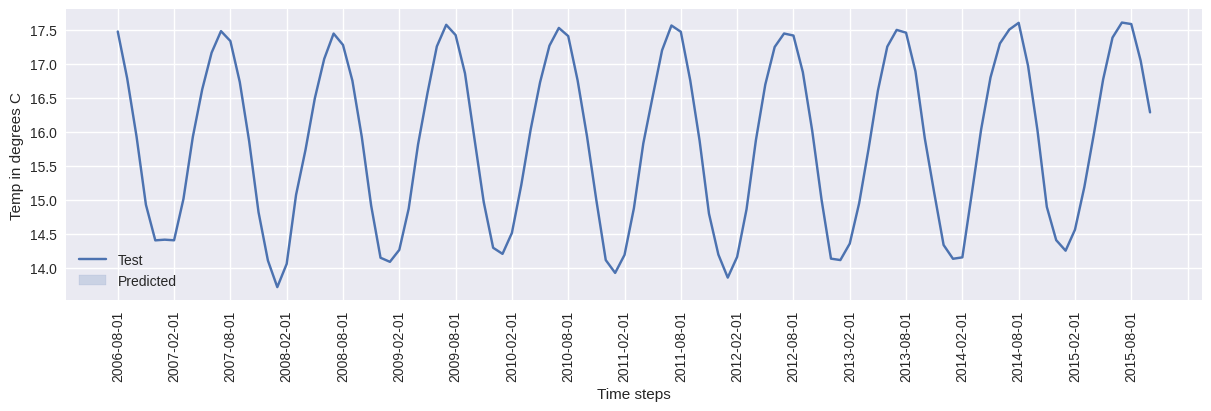

In [131]:
# Plot results
# max points - default to full set
TICK_SPACING=6
fig, ax = plt.subplots(figsize=(12,4), layout="constrained")
sns.lineplot(data=df_results, ax=ax)
ax.set_xticks(df_results.index, labels=date_labels, rotation=90)
ax.xaxis.set_major_locator(plticker.MultipleLocator(TICK_SPACING))
plt.xlabel('Time steps')
plt.ylabel('Temp in degrees C')
plt.legend(('Test','Predicted'))

**Error Calculations**

In [132]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [133]:
f

In [141]:
# y_test_vals = y_test_vals.reshape(y_test_vals.shape[0],1)
# preds = preds.reshape(preds.shape[0],1)
# y_test_vals.shape, preds.shape

In [146]:
# Calculate MAPE
m = tf.keras.metrics.MeanAbsolutePercentageError()
try:
  m.update_state(y_test_vals, preds)
except ValueError as ve:
  print(f'ValueError calculating MAPE: {ve}')

ValueError calculating MAPE: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).


In [136]:
mse = mean_squared_error(y_test_vals, preds)
mae = mean_absolute_error(y_test_vals, preds)
mape = m.result().numpy()/100  # adjust Keras output to match scikit
from sklearn.metrics import mean_absolute_percentage_error
sk_mape = mean_absolute_percentage_error(y_test_vals, preds)

In [137]:
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'SKMAPE: {sk_mape}')

MSE: 0.07519701198509907
MAE: 0.229042870255204
MAPE: 0.0
SKMAPE: 0.014416527219144088


**Journal entry**

In [ ]:
import csv

In [ ]:
def current_time_ms():
  return dt.now().microsecond

In [ ]:
serial = current_time_ms()

In [ ]:
# write pred results out
df_results.to_csv(LOG_PATH +  f'model-preds-{serial}.csv', index_label='index')

In [ ]:
# Save model
model.save_model(LOG_PATH, serial)

In [ ]:
with open(JOURNAL_LOG, 'a') as csvfile:
  writer = csv.writer(csvfile)
  #writer.writerow(['DateTime','Serial','Model','TargetLabel','NumFeatures','WindowSize','TestPct','NumEpochs','MSE','MAE','MAPE','SKMAPE','Columns'])
  writer.writerow([dt.today().strftime("%Y%m%d-%H%M"),serial,MODEL_NAME,TARGET_LABEL,NUM_FEATURES,INPUT_WINDOW,TEST_RATIO,num_epochs,mse,mae,mape,sk_mape,COLS])